### **Práctica 2 - Machine Learning III**

**Objetivo**: 
1. Analizar el conjunto de datos. 
2. Crear un sistema de recomendación de artistas para usuarios.
   
**Entregar**: Este cuaderno de jupyter con el trabajo hecho y comentado.

**Datos**: 

Los datos suministrados ya han sido procesados, limpiados y estructurados para simplificar su manejo y análisis. 

Para aquellos interesados en explorar y manipular el conjunto de datos original, así como entender la estructura, podéis descargarlo directamente aquí: 

https://grouplens.org/datasets/hetrec-2011/.

In [ ]:
### ARCHIVOS DE DATOS DISPONIBLES: 
#1. artists.dat: info de los artistas que escuchan y etiquetan (tag) los users
#2. tags.dat: info de los tags que se pueden asignar a los artistas
#3. user_artists.dat: info de los artistas que escuchan los usuarios
#4. user_friends.dat: info de los amigos de los usuarios
#5. user_taggedartists.dat: tags que los usuarios asignan a los artistas
#6. user_taggedartists-timestamps.dat: igual que el anterior pero con timestamps

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [2]:
#Info artistas
artists.head()

,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147
3,227,The Beatles,480,3658694
4,300,Katy Perry,473,3721531


In [3]:
#artistas escuchados por cada usuario. 
### Sobre weight: 
#listening count para cada [user,artist] pair.
#Me imagino que serán los minutos.
#Podemos utilizarlo como rating, más minutos, más le gusta.

users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [4]:
#Tag que el usuario asigna a un artista, y en el momento en el que se lo asignó.
user_tag_artist.head()


,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [5]:
#POSIBLES TAGS QUE SE PUEDEN ASIGNAR:
print("\nInformación de etiquetas:")
print(tags.head())



Información de etiquetas:
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


In [7]:
#Artistas con más listeners.
artists.sort_values(by='listeners', ascending=False).head(10)

,artistID,name,freq,listeners
12,65,Coldplay,369,5369132
11,154,Radiohead,393,4718748
38,220,Red Hot Chili Peppers,222,4608144
2,288,Rihanna,484,4542147
43,475,Eminem,204,4504111
16,229,The Killers,304,4416820
81,331,Kanye West,134,4375723
24,234,Nirvana,258,4257983
8,190,Muse,400,4080161
42,959,Queen,208,4002970


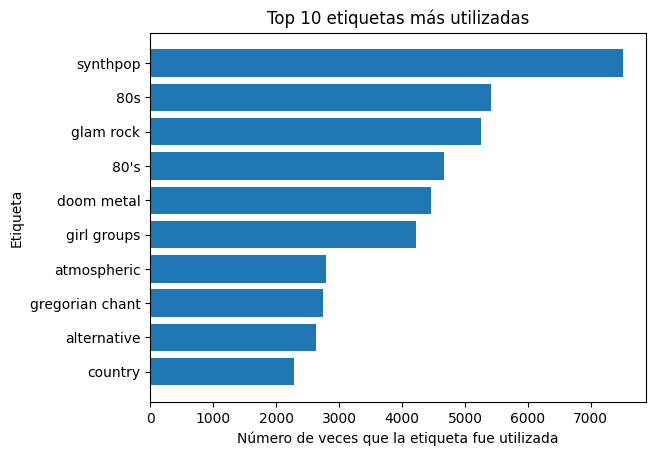

In [9]:
# Contar la frecuencia de aparición de las etiquetas
tag_counts = user_tag_artist['tagID'].value_counts().sort_values(ascending=False)[:10]
top_tags = tags.loc[tag_counts.index]['tagValue']

plt.barh(top_tags, tag_counts)
plt.xlabel('Número de veces que la etiqueta fue utilizada')
plt.ylabel('Etiqueta')
plt.title('Top 10 etiquetas más utilizadas')
plt.gca().invert_yaxis()
plt.show()


### PLANTEAMIENTO DEL PROBLEMA: 
- Problema: Lo que queremos es proporcionar recomendaciones de artistas nuevos a un usuario. 
- Es un problema implícito ya que no tenemos ratings/calificaciones explícitas como tal, si no que tenemos el número de minutos escuchados.

#### User-based collaborative filtering: 
- Solución: Buscar usuarios que sean similares al usuario target para poder hacer las recomendaciones. 

- Vamos a utilizar la matriz de usuarios-artistas (Sería la matriz de ratings): 
    - Dimensiones: (mxn), m usuarios, n artistas.
    - Cada fila de la matriz es un usuario y cada columna es un artista.
    - Cada celda es el número de veces/minutos que el usuario escuchó al artista (weight)

- Cómo calcular la similitud entre usuarios? 
    - Utilizando similitud del coseno 
    - Utilizando fórmula de Pearson

- Cuando tengamos los k usuarios más similares a nuestro usuario target u (Basado en similitud)
    - Para los artistas que u no ha escuchado crearemos un rating basado en lo que los k usuarios calificaron ponderado por su peso (similitud)
    - Ordenamos por rating descendente y hacemos top-n recomendaciones. 


In [10]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
# Merge users and artist datasets
df = pd.merge(users, artists, on='artistID', how='inner')

# Take a look at the data
df.head()

,userID,artistID,weight,name,freq,listeners
0,2,51,13883,Duran Duran,111,1588349
1,4,51,228,Duran Duran,111,1588349
2,27,51,85,Duran Duran,111,1588349
3,28,51,10,Duran Duran,111,1588349
4,62,51,528,Duran Duran,111,1588349


In [20]:
df['weight'].mean()

816.4413876218122

USO WEIGHT COMO EL RATING NO SE SI ESTA BIEN 

In [26]:
# Aggregate by artist
agg_ratings = df.groupby('name').agg(mean_rating = ('weight', 'mean'),
                                                number_of_ratings = ('weight', 'count')).reset_index()

# Keep the artist with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 20 to 4440
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               125 non-null    object 
 1   mean_rating        125 non-null    float64
 2   number_of_ratings  125 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.9+ KB


In [27]:
# Check popular artists
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,name,mean_rating,number_of_ratings
2231,Lady Gaga,2113.563011,611
645,Britney Spears,4584.559387,522
3205,Rihanna,1870.708678,484
3731,The Beatles,1379.408333,480
2123,Katy Perry,1125.887949,473


/usr/local/Caskroom/miniforge/base/envs/envml3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/Caskroom/miniforge/base/envs/envml3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


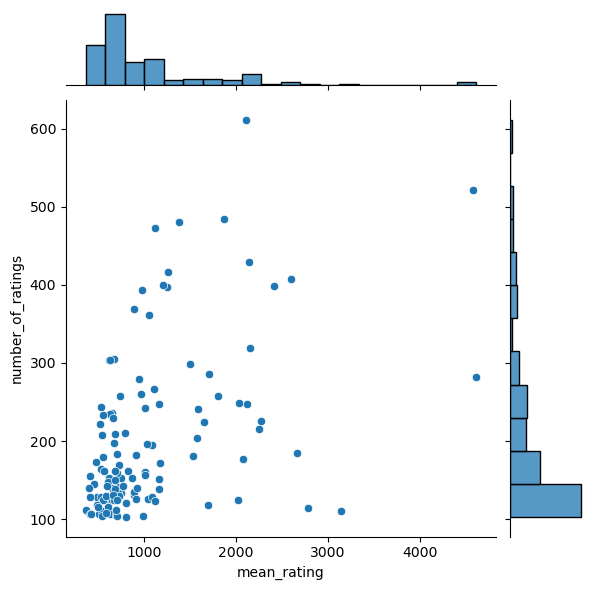

In [28]:
# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [29]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['name']], on='name', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24809 entries, 0 to 24808
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userID     24809 non-null  int64 
 1   artistID   24809 non-null  int64 
 2   weight     24809 non-null  int64 
 3   name       24809 non-null  object
 4   freq       24809 non-null  int64 
 5   listeners  24809 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [30]:
# Number of artists
print('The ratings dataset has', df_GT100['artistID'].nunique(), 'unique artists')

# Number of users
print('The ratings dataset has', df_GT100['userID'].nunique(), 'unique users')

# Number of weights
print('The ratings dataset has', df_GT100['weight'].nunique(), 'unique weights')

# List of unique ratings
print('The unique weights are', sorted(df_GT100['weight'].unique()))

The ratings dataset has 125 unique artists
The ratings dataset has 1813 unique users
The ratings dataset has 3944 unique weights
The unique weights are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 

In [31]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userID', columns='name', values='weight')
matrix.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374.0,259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,809.0,1553.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.904762,-6.095238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,-3179.666667,-2435.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userID,2,4,5,6,7,8,9,10,11,12,...,2086,2087,2088,2090,2091,2092,2093,2094,2096,2097
userID,,,,,,,,,,,,,,,,,,,,,
2,1.000000,-0.576091,NaN,NaN,-0.547734,NaN,NaN,NaN,-1.000000,NaN,...,NaN,-0.549090,-1.000000,NaN,-1.0,NaN,NaN,NaN,NaN,-0.421803
4,-0.576091,1.000000,0.544016,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.581765,0.999703
5,NaN,0.544016,1.000000,NaN,NaN,NaN,NaN,-0.456452,-1.000000,NaN,...,0.842446,NaN,0.675617,1.0,NaN,0.287328,NaN,NaN,0.260677,0.059629
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.547734,NaN,NaN,NaN,1.000000,-0.056068,NaN,NaN,0.165719,-0.452562,...,NaN,0.040023,0.631912,NaN,NaN,NaN,NaN,-0.868406,NaN,NaN


In [34]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        , -0.27311313,  0.        , ...,  0.051086  ,
         0.04379327, -0.15481241],
       [-0.27311313,  1.        , -0.08726293, ...,  0.        ,
        -0.02760951,  0.85320862],
       [ 0.        , -0.08726293,  1.        , ...,  0.        ,
         0.02241791,  0.01037731],
       ...,
       [ 0.051086  ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.04379327, -0.02760951,  0.02241791, ...,  0.        ,
         1.        ,  0.03833763],
       [-0.15481241,  0.85320862,  0.01037731, ...,  0.        ,
         0.03833763,  1.        ]])

In [36]:
# Pick a user ID
picked_userid = 2

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userID,2,4,5,6,7,8,9,10,11,12,...,2086,2087,2088,2090,2091,2092,2093,2094,2096,2097
userID,,,,,,,,,,,,,,,,,,,,,
4,-0.576091,1.000000,0.544016,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.581765,0.999703
5,NaN,0.544016,1.000000,NaN,NaN,NaN,NaN,-0.456452,-1.000000,NaN,...,0.842446,NaN,0.675617,1.0,NaN,0.287328,NaN,NaN,0.260677,0.059629
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.547734,NaN,NaN,NaN,1.000000,-0.056068,NaN,NaN,0.165719,-0.452562,...,NaN,0.040023,0.631912,NaN,NaN,NaN,NaN,-0.868406,NaN,NaN
8,NaN,NaN,NaN,NaN,-0.056068,1.000000,NaN,NaN,0.705680,0.997594,...,NaN,0.537092,-0.447645,NaN,NaN,NaN,NaN,-0.375799,NaN,NaN


In [37]:
# most similar users 
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 2 are userID
1102    1.0
643     1.0
1339    1.0
1474    1.0
1471    1.0
1458    1.0
1419    1.0
1411    1.0
1383    1.0
1134    1.0
Name: 2, dtype: float64


we will narrow down the item pool by doing the following:
1. Remove the artists that have been listened by the target user (user ID 1 in this example).
2. Keep only the artists that similar users have listened.

To remove the artists listened by the target user, we keep only the row for `userId=2` in the user-item matrix and remove the items with missing values.

In [38]:
# artists that the target user has listened to
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

name,Coldplay,Daft Punk,Depeche Mode,Duran Duran,Gorillaz,Kylie Minogue,Lady Gaga,Madonna,New Order,Portishead
userID,,,,,,,,,,
2,-1208.4,1364.6,-2168.4,9095.6,-3234.4,4195.6,-3268.4,-1486.4,-450.4,-2839.4


To keep only the similar users' movies, we keep the user IDs in the top 10 similar user lists and remove the film with all missing values. All missing value for a movie means that none of the similar users have watched the movie.


In [39]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

name,30 Seconds to Mars,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,Ashlee Simpson,Avril Lavigne,Beyoncé,Björk,...,Snow Patrol,System of a Down,The Beatles,The Doors,The Killers,The Kooks,The Pussycat Dolls,The Smashing Pumpkins,The Smiths,The Strokes
userID,,,,,,,,,,,,,,,,,,,,,
643,NaN,NaN,NaN,NaN,-50.818182,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.818182,-205.818182,NaN
1102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-454.583333,NaN,NaN,NaN,NaN,NaN
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1339,NaN,NaN,NaN,NaN,NaN,-4183.96,NaN,-6656.960000,NaN,NaN,...,-8008.96,NaN,-5177.96,NaN,-5367.960000,-7909.96,NaN,NaN,NaN,-4293.96
1383,NaN,NaN,NaN,NaN,NaN,-824.50,NaN,NaN,NaN,1924.5,...,NaN,NaN,1262.50,-787.500000,NaN,NaN,NaN,NaN,NaN,NaN
1411,NaN,-339.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-355.307692,NaN,NaN,NaN,NaN,NaN,NaN
1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-205.00,-183.0,NaN,NaN,54.000000,NaN,NaN,NaN,NaN,NaN
1458,13.714286,10.714286,-21.285714,19.714286,NaN,NaN,-0.285714,10.714286,19.714286,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1471,NaN,-1844.275862,NaN,NaN,NaN,NaN,NaN,NaN,-1691.275862,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1852.275862,NaN,NaN,NaN


In [40]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

name,30 Seconds to Mars,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,Ashlee Simpson,Avril Lavigne,Beyoncé,Björk,...,Snow Patrol,System of a Down,The Beatles,The Doors,The Killers,The Kooks,The Pussycat Dolls,The Smashing Pumpkins,The Smiths,The Strokes
userID,,,,,,,,,,,,,,,,,,,,,
643,NaN,NaN,NaN,NaN,-50.818182,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.818182,-205.818182,NaN
1102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-454.583333,NaN,NaN,NaN,NaN,NaN
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1339,NaN,NaN,NaN,NaN,NaN,-4183.96,NaN,-6656.960000,NaN,NaN,...,-8008.96,NaN,-5177.96,NaN,-5367.960000,-7909.96,NaN,NaN,NaN,-4293.96
1383,NaN,NaN,NaN,NaN,NaN,-824.50,NaN,NaN,NaN,1924.5,...,NaN,NaN,1262.50,-787.500000,NaN,NaN,NaN,NaN,NaN,NaN
1411,NaN,-339.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-355.307692,NaN,NaN,NaN,NaN,NaN,NaN
1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-205.00,-183.0,NaN,NaN,54.000000,NaN,NaN,NaN,NaN,NaN
1458,13.714286,10.714286,-21.285714,19.714286,NaN,NaN,-0.285714,10.714286,19.714286,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1471,NaN,-1844.275862,NaN,NaN,NaN,NaN,NaN,NaN,-1691.275862,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1852.275862,NaN,NaN,NaN


In [41]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'artist_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='artist_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,artist,artist_score
55,Paramore,18150.642333
14,Britney Spears,13766.285030
36,Kings of Leon,5979.770000
9,Björk,1924.500000
19,Eminem,266.000000
23,Florence + the Machine,209.181818
3,Amy Winehouse,19.714286
0,30 Seconds to Mars,13.714286
6,Ashlee Simpson,-0.285714
50,Nickelback,-2.909091


predict score 

In [42]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 2 is 4787.40


In [44]:
# Calcuate the predicted rating
ranked_item_score['predicted_rating'] = ranked_item_score['artist_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,artist,artist_score,predicted_rating
55,Paramore,18150.642333,22938.042333
14,Britney Spears,13766.285030,18553.685030
36,Kings of Leon,5979.770000,10767.170000
9,Björk,1924.500000,6711.900000
19,Eminem,266.000000,5053.400000
23,Florence + the Machine,209.181818,4996.581818
3,Amy Winehouse,19.714286,4807.114286
0,30 Seconds to Mars,13.714286,4801.114286
6,Ashlee Simpson,-0.285714,4787.114286
50,Nickelback,-2.909091,4784.490909
